In [42]:
import pandas as pd
import scipy
pd.set_option("display.precision", 3)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import itertools
from tqdm import tqdm
%matplotlib inline
from sklearn.metrics import accuracy_score,log_loss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
#https://python-course.eu/numerical-programming/creating-subplots-in-matplotlib.php

In [43]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

train['date'] = pd.to_datetime(train.date)
test['date'] = pd.to_datetime(test.date)


train=train.sort_values(["date","device","site_latitude"]).reset_index(drop=True)
test=test.sort_values(["date","device","site_latitude"]).reset_index(drop=True)
train=train.set_index("date")
test=test.set_index("date")

#those blabla_angle are to be deleted
angle_name=train.loc[:,train.columns.str.contains("angle")].columns
train.drop(angle_name,axis=1,inplace=True)
test.drop(angle_name,axis=1,inplace=True)


In [44]:
train

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,pm2_5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-14,ID_CE4DAC712J,aq_30,0.060,32.460,0.847,22.642,-2.511e-04,0.528,-1.326e-04,0.117,-5.718e-05,NaN,NaN,NaN,NaN,4.064e-05,5.087e-06,3.555e-05,1.005e-04,8613.749,-0.703,0.089,829857.375,-3.788e-05,0.870,-9.342e-05,0.117,-0.703,829857.375,0.121,2.709,0.332,233.324,0.120,0.177,25944.070,9897.856,30049.924,8889.992,5.467,0.207,31.415
2019-03-15,ID_HIQKM4CT8J,aq_30,0.060,32.460,0.784,24.325,-1.323e-04,0.563,-7.446e-05,0.024,-3.792e-05,0.031,2888.998,404.195,829761.250,4.104e-05,6.239e-06,3.480e-05,8.029e-05,7311.869,-1.184,0.017,829779.750,1.105e-04,0.830,3.044e-05,0.024,-1.184,829779.750,0.121,2.201,0.269,228.397,0.025,0.025,80723.172,1156.244,88145.250,1156.244,5.078,0.241,28.940
2019-03-16,ID_RBKKDULJSK,aq_30,0.060,32.460,0.742,25.725,-1.693e-04,0.551,-9.322e-05,0.031,-4.860e-05,0.032,1813.223,1.000,829616.938,5.071e-05,1.426e-05,3.645e-05,9.370e-05,8613.745,-0.455,0.048,829634.250,5.270e-05,0.853,-3.262e-05,0.031,-0.455,829634.250,0.121,2.084,0.257,231.321,0.032,0.032,88152.937,1156.242,88152.937,1156.242,5.076,0.221,34.349
2019-03-17,ID_AAI6SF03WX,aq_30,0.060,32.460,0.748,24.608,-2.863e-04,0.670,-1.917e-04,0.000,-8.627e-05,0.032,2115.601,1476.049,829422.000,4.474e-05,9.603e-06,3.514e-05,9.836e-05,8613.751,-1.574,0.025,829445.125,1.210e-04,0.975,4.475e-05,0.000,-1.574,829445.125,0.121,2.395,0.295,229.095,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.132
2019-03-18,ID_TBMFQGXQ5D,aq_30,0.060,32.460,0.736,24.858,-1.203e-04,0.656,-7.896e-05,0.010,-3.006e-05,0.030,1881.767,173.602,829230.250,3.429e-05,-1.023e-06,3.531e-05,1.080e-04,8613.752,-1.281,0.016,829263.125,2.200e-04,1.111,1.679e-04,0.010,-1.281,829263.125,0.120,3.035,0.372,228.902,0.006,0.006,83932.567,1157.109,88179.423,1157.109,4.536,0.154,30.584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-20,ID_W1RFPTL457,aq_29,0.307,32.621,0.806,22.701,3.997e-05,0.902,3.605e-05,0.282,1.755e-05,0.047,2749.195,3291.663,829581.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.672e-04,1.082,3.354e-04,0.282,-2.057,829601.562,0.121,2.198,0.271,225.549,0.282,0.274,59117.333,4582.555,66717.371,3582.555,2.723,0.210,45.812
2020-08-20,ID_I2EPK1C0F4,aq_45,0.344,32.553,0.831,21.795,NaN,NaN,NaN,NaN,NaN,0.042,3733.554,4540.650,829575.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.902,829592.996,0.121,2.200,0.271,222.084,0.618,0.542,42298.322,7239.254,47831.250,6239.254,4.492,0.237,58.268
2020-08-20,ID_3B3J6AZCEI,aq_57,0.355,32.503,0.831,21.935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### few concepts:
**pm2_5: PM2.5 refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers,** Fine particles can come from various sources. They include power plants, motor vehicles, airplanes, residential wood burning, forest fires, agricultural burning, volcanic eruptions and dust storms. Some are emitted directly into the air, while others are formed when gases and particles interact with one another in the atmosphere.
For instance, gaseous sulfur dioxide emitted from power plants reacts with oxygen and water droplets in the air to form sulfuric acid as a secondary particle. 

<AxesSubplot:ylabel='Density'>

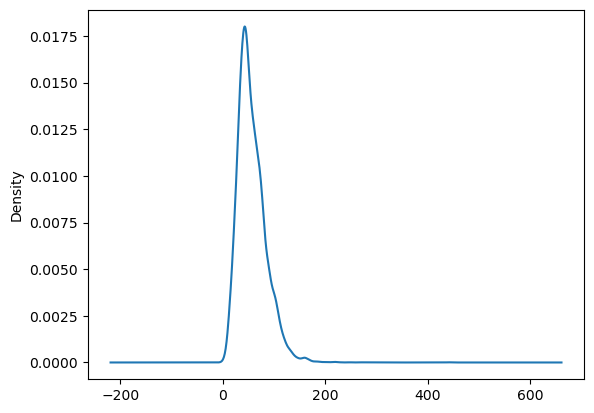

In [45]:
train["pm2_5"].plot.density()

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9923 entries, 2019-03-14 to 2020-08-20
Data columns (total 42 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID                                                        9923 non-null   object 
 1   device                                                    9923 non-null   object 
 2   site_latitude                                             9923 non-null   float64
 3   site_longitude                                            9923 non-null   float64
 4   humidity                                                  9923 non-null   float64
 5   temp_mean                                                 9903 non-null   float64
 6   SulphurDioxide_SO2_column_number_density                  4291 non-null   float64
 7   SulphurDioxide_SO2_column_number_density_amf              4291 non-null   float64
 8   

In [47]:
cols_with_missing = [col for col in train.columns
                     if train[col].isnull().any()]
len(cols_with_missing)

36

In [48]:
len(train.columns)

42

# Data Exploratory

## Missing values

In [49]:
percent_missing_train = train.isnull().sum() * 100 / len(train)
percent_missing_test = test.isnull().sum() * 100 / len(test)

missing_value_df = pd.DataFrame({'percent_missing_train': percent_missing_train,'percent_missing_test': percent_missing_test})
#missing_value_df.sort_values('percent_missing_train', inplace=True)
missing_value_df.head(50)

,percent_missing_train,percent_missing_test
CarbonMonoxide_CO_column_number_density,44.946,50.588
CarbonMonoxide_H2O_column_number_density,44.946,50.588
CarbonMonoxide_cloud_height,44.946,50.588
CarbonMonoxide_sensor_altitude,44.946,50.588
Cloud_cloud_base_height,15.207,12.106
Cloud_cloud_base_pressure,15.207,12.106
Cloud_cloud_fraction,15.207,12.106
Cloud_cloud_optical_depth,15.207,12.106
Cloud_cloud_top_height,15.207,12.106
Cloud_cloud_top_pressure,15.207,12.106


<AxesSubplot:>

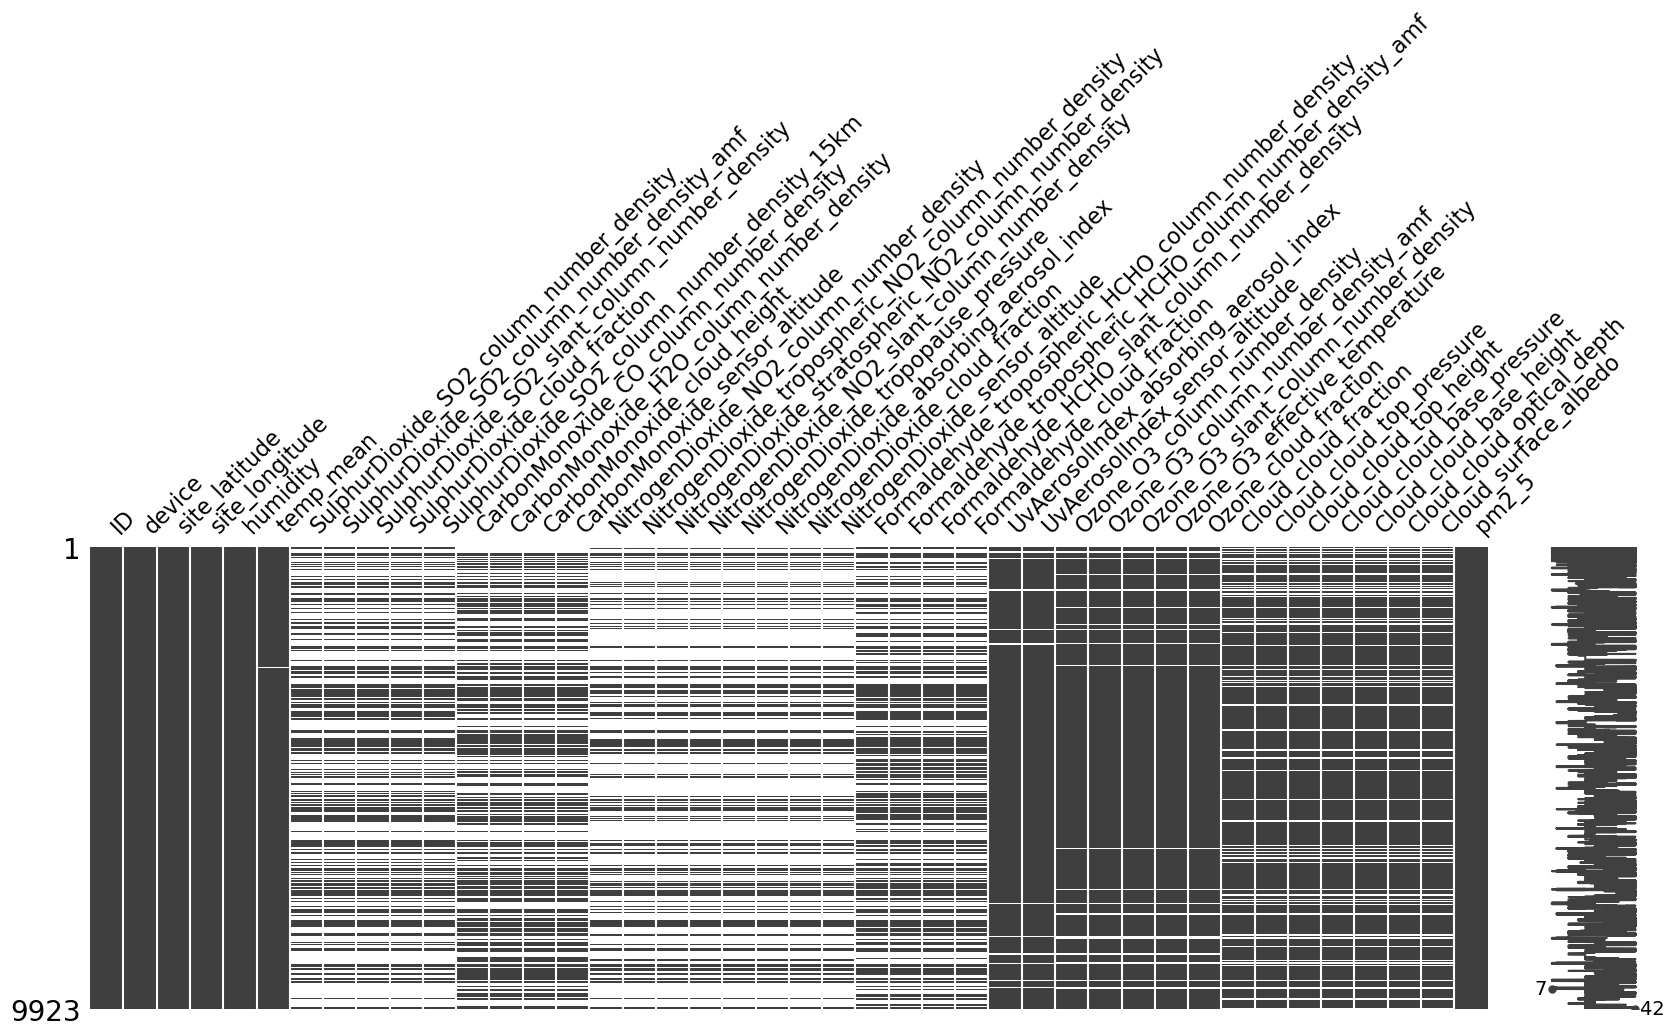

In [50]:
import missingno as mno
mno.matrix(train, figsize = (20, 6))

<AxesSubplot:>

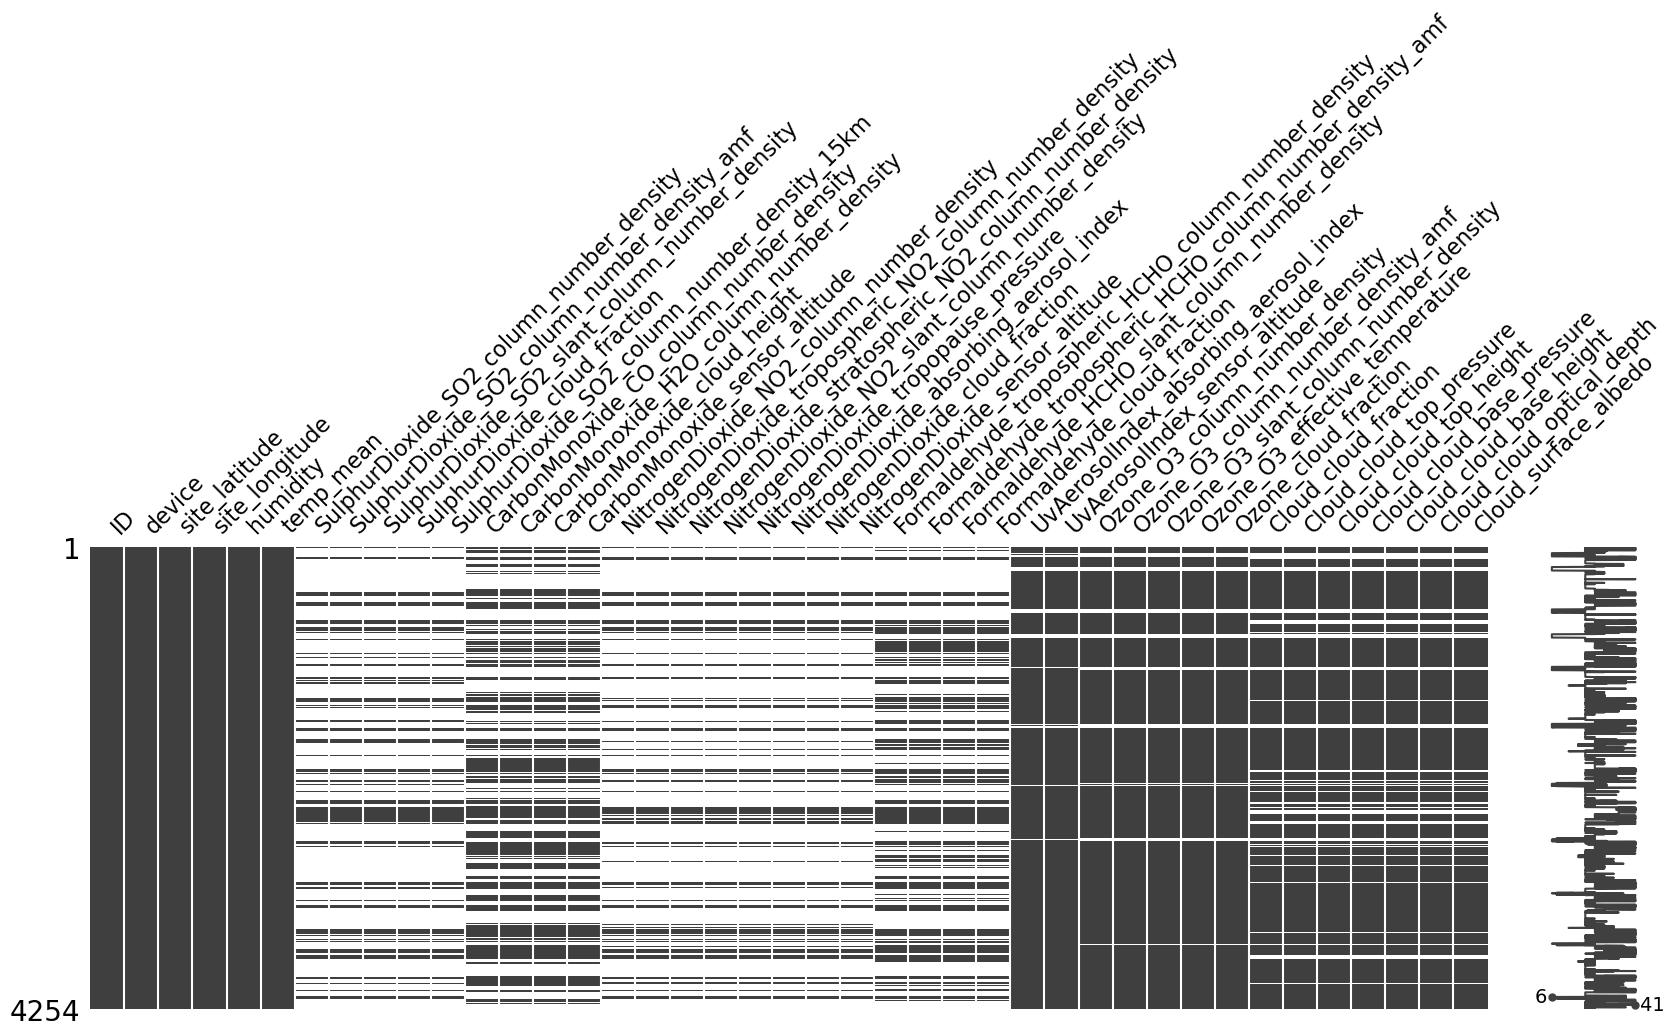

In [51]:
mno.matrix(test, figsize = (20, 6))

## pm2_5

<AxesSubplot:xlabel='date'>

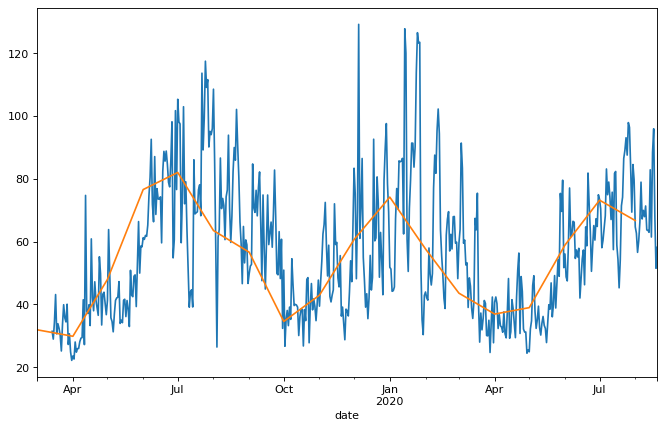

In [52]:
fig =plt.figure(figsize=(10, 6), dpi=80)

train.resample('1D').mean()["pm2_5"].plot()  # 1 day mean
train.resample('1M').median()["pm2_5"].plot() # 1 month mean
#train.resample('1M').max()["pm2_5"].plot()
#train.resample('1M').min()["pm2_5"].plot()

**from the the figure above we can conclude: that the pm2_5 data is seasonality**

In [53]:
# train_default_index 
train_default_index=train.resample('1D').mean().reset_index(drop=True)

# convert the datetime index to ordinal values, which can be used to plot a regression line
train_default_index.index = train.resample('1D').mean().index.map(pd.Timestamp.toordinal)
train_default_index1=train_default_index.reset_index()

intercept: [-9054.28897113]
slope: [[0.01235646]]
[[54.0506886]]
[[60.53782838]]


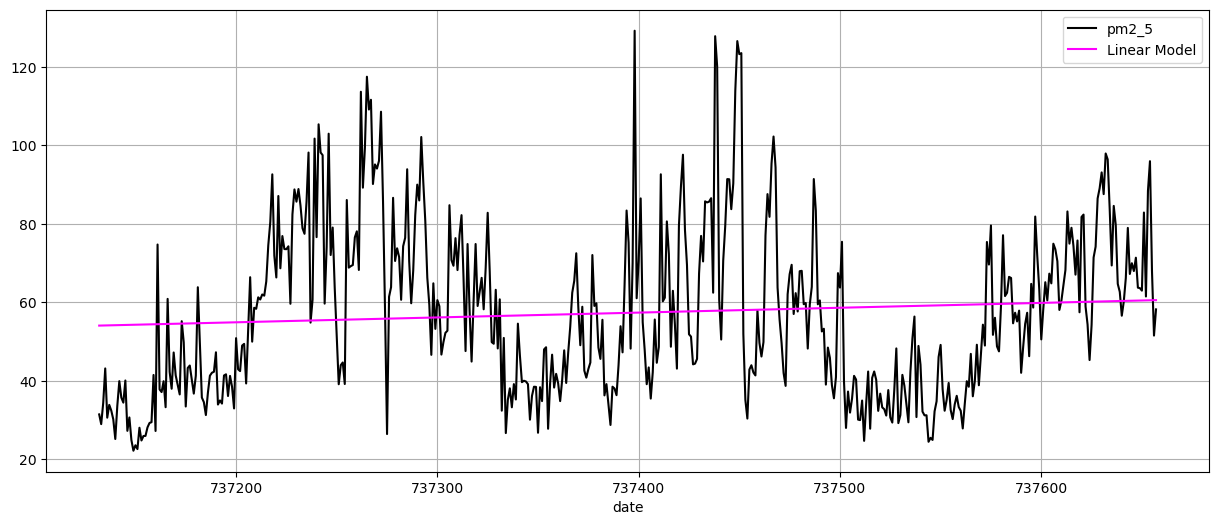

In [54]:
from sklearn.linear_model import LinearRegression

# create the model
model = LinearRegression()

# extract x and y from dataframe data
x = train_default_index1[['date']]
y = train_default_index1[['pm2_5']]

# fit the mode
model.fit(x, y)

# print the slope and intercept if desired
print('intercept:', model.intercept_)
print('slope:', model.coef_)

x1 = pd.to_datetime('2019-03-14').toordinal()

# calculate y1, given x1
y1 = model.predict(np.array([[x1]]))

print(y1)


# calculate y2, given the last date in data
x2 = train_default_index1.date.iloc[-1]
y2 = model.predict(np.array([[x2]]))

print(y2)


# this can be added to `ax1` with
ax1 = train_default_index.plot(y='pm2_5', c='k', figsize=(15, 6), grid=True, legend=False,
              )
ax1.plot([x1, x2], [y1[0][0], y2[0][0]], label='Linear Model', c='magenta')
ax1.legend()

## device
https://aqicn.org/station/network/airqo

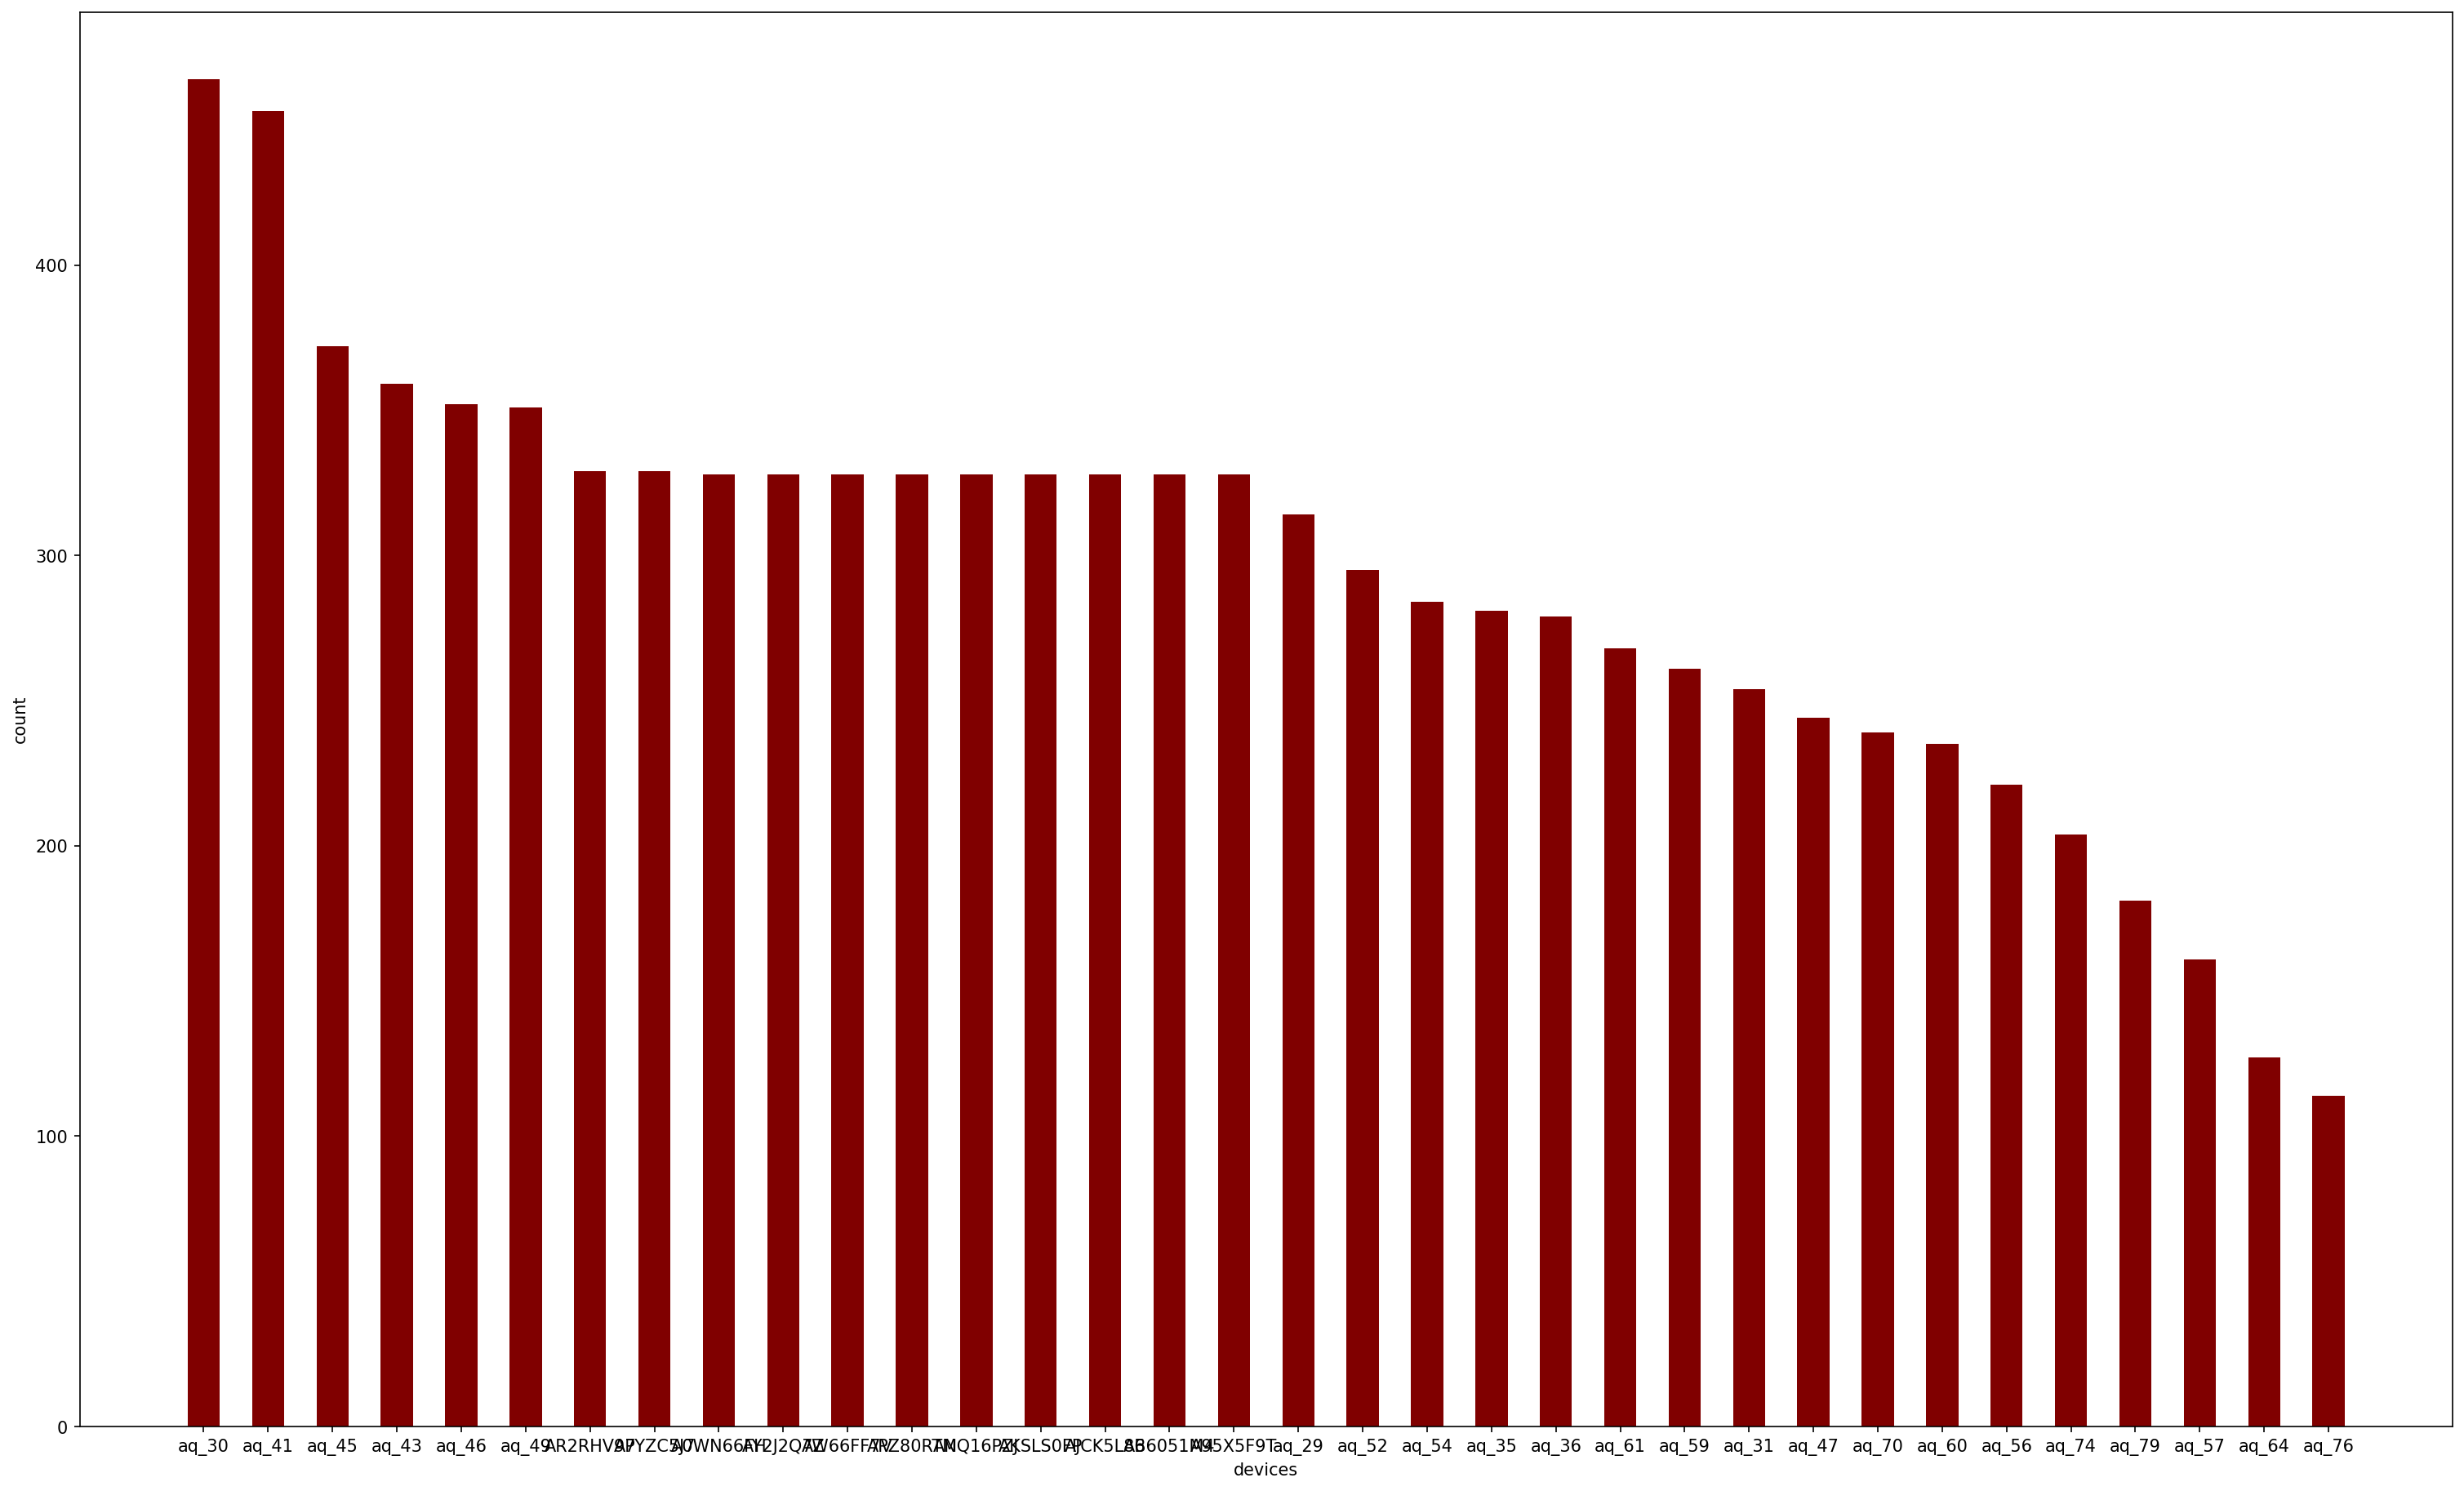

In [55]:
devices_frequency=dict(train.device.value_counts())
device = list(devices_frequency.keys())
frequency = list(devices_frequency.values())
  
fig = plt.figure(figsize = (25, 15),dpi=150)
 
# creating the bar plot
plt.bar(device, frequency, color ='maroon',
        width = 0.5)
 
plt.xlabel("devices")
plt.ylabel("count")
plt.show()

<AxesSubplot:>

<Figure size 3750x2250 with 0 Axes>

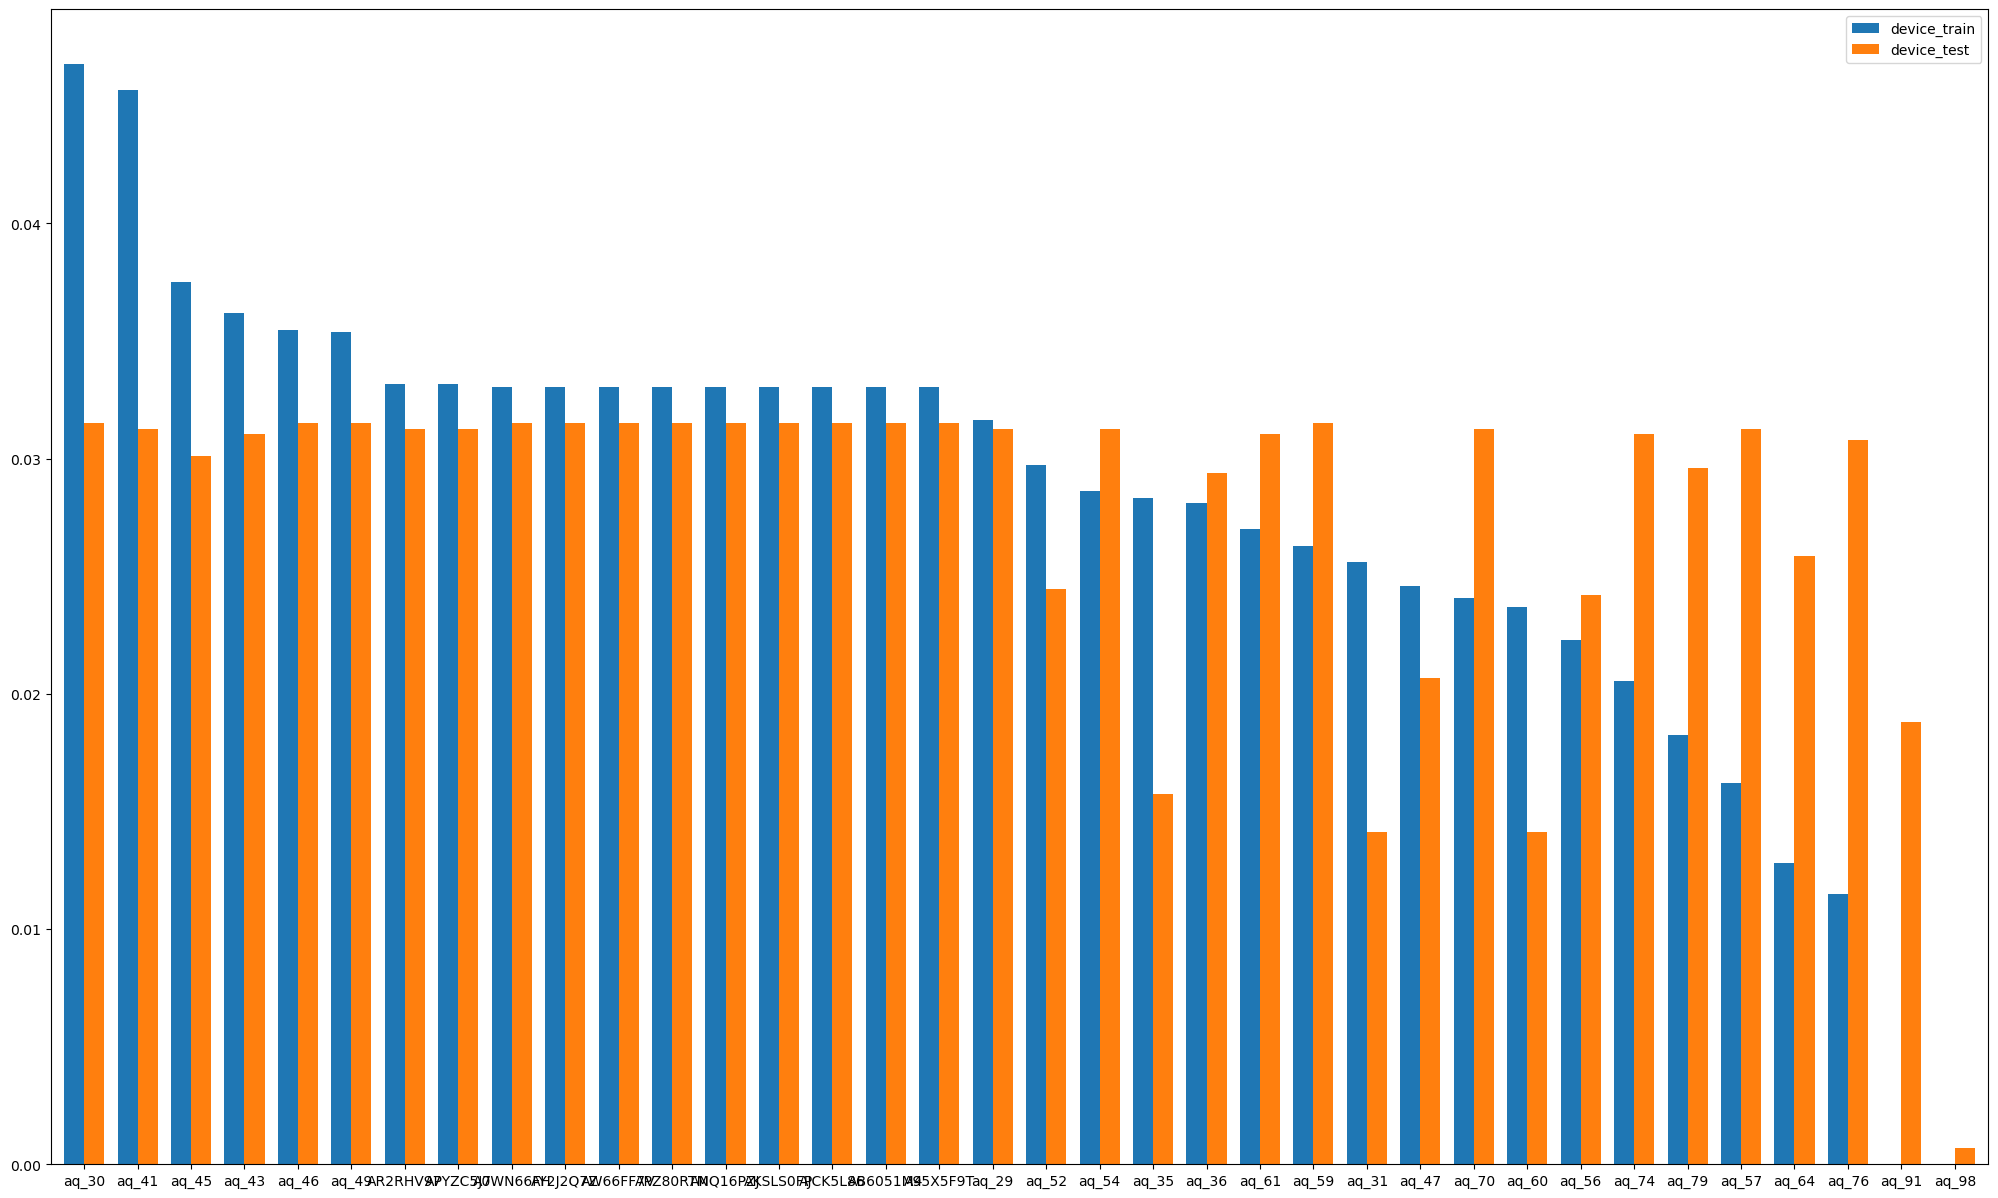

In [56]:
# let's see are the device used in the train the same as test? what about the frequency in each dataset ?

fig = plt.figure(figsize = (25, 15),dpi=150)

s1=(train["device"].value_counts()/train["device"].value_counts().sum()).rename('device_train')
s2=(test["device"].value_counts()/test["device"].value_counts().sum()).rename('device_test')
df=pd.concat([s1, s2], axis=1).fillna(0)
df.plot.bar(rot=0,figsize=(25,15),width = 0.75)

# there are 2 new devices in the test 
# we can see that in the test almost all devices are used equaly (with some exception) while it's not the case in the train set

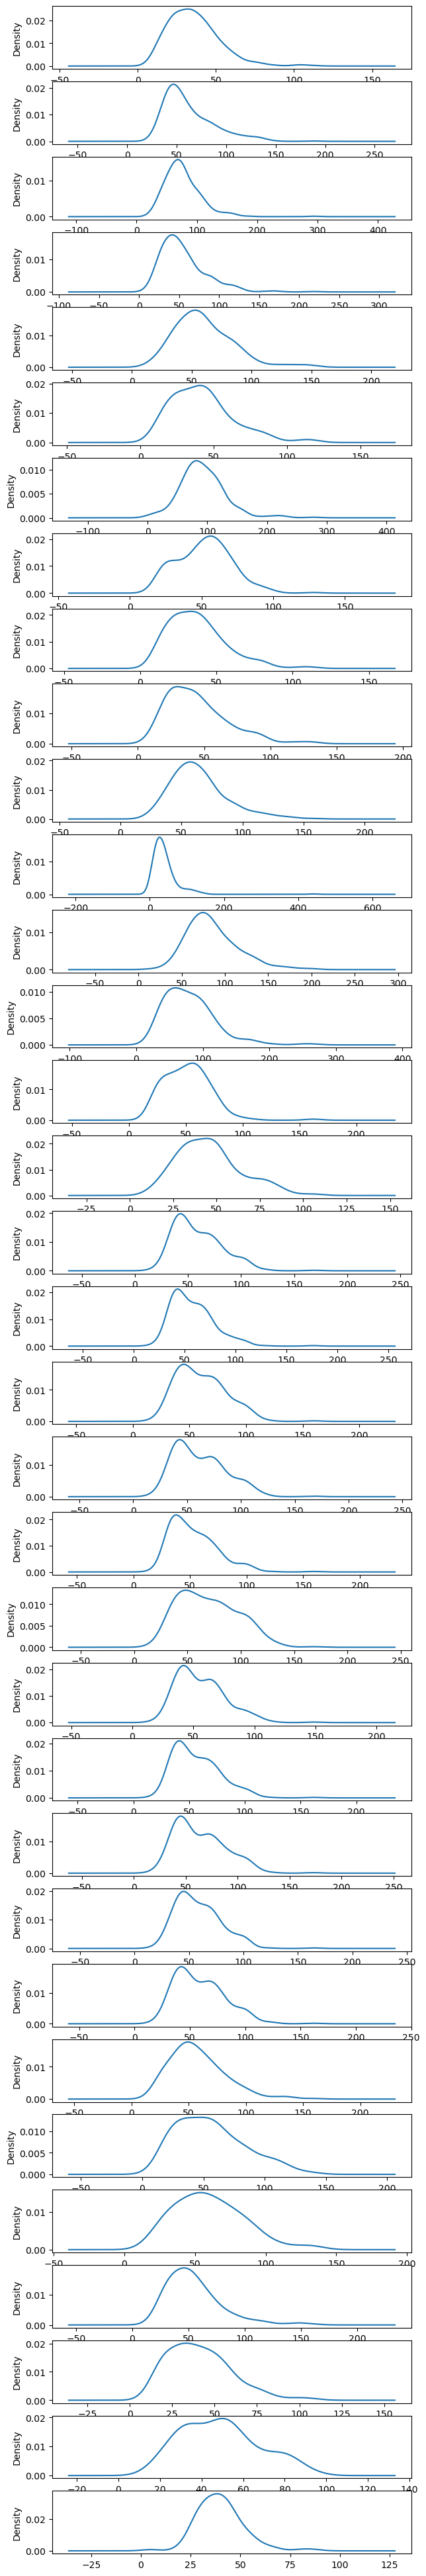

In [57]:
# pm2_5 for each device 
fig, ax = plt.subplots(34,figsize=(7, 50))
devices=train["device"].unique()
for i,device in enumerate(devices):
    train[train["device"]==device]["pm2_5"].plot.density(ax=ax[i])
# they are quite different:
#this can be explained for some reason which I suspect the following:
#  Some devices are not put in the same region
#  they are not put in the same period

# The main goal is to fill the none values


In [58]:
for device in train["device"].unique():
    print(device+":")
    print(train.loc[train["device"]==device,'site_latitude'].std())
    print(train.loc[train["device"]==device,'site_longitude'].std())

    print("\n")

aq_30:
2.0144511477487151e-16
1.138095434645343e-13


aq_41:
4.445801875675633e-16
1.3672618167033637e-13


aq_45:
2.5013661191270203e-15
1.0672495441608619e-13


aq_43:
0.0
1.209608517140547e-13


aq_47:
1.047358091696498e-15
1.281605862238534e-13


aq_29:
7.783965906802985e-16
1.4233537658154028e-13


aq_31:
1.1680357263218523e-15
1.210307495464929e-13


aq_36:
1.5571052506262958e-15
0.0


aq_46:
1.4453444382940332e-15
1.778885462515733e-13


aq_49:
5.003135668135608e-16
2.0635155111243755e-13


aq_35:
1.3865649347625411e-15
5.694483449694535e-14


aq_52:
1.343923078493632e-15
2.2776003710752067e-13


aq_54:
2.0019290753927474e-15
1.5659534100849936e-13


aq_56:
6.120088688772652e-16
1.3530959719177355e-13


aq_57:
7.268702509002211e-16
1.0691395847433796e-13


aq_60:
5.562963834842063e-17
3.56029685429892e-14


A0WN66FH:
0.0
1.7079080716459252e-13


A95X5F9T:
1.38989914684727e-15
2.846513452743209e-14


AB6051M4:
2.8909902254423214e-15
3.558141815929011e-14


AJCK5L86:
1.11191931747

In [59]:
# as expected all devices have a fixed location
# it's even safe to run this code:
for device in train["device"].unique():
    print(device+":")
    print(train.loc[train["device"]==device,'site_latitude'].unique())
    print(train.loc[train["device"]==device,'site_longitude'].unique())

    print("\n")

aq_30:
[0.059604]
[32.46032]


aq_41:
[-1.244985]
[29.989236 29.989236]


aq_45:
[0.344]
[32.553]


aq_43:
[0.28904]
[32.58958]


aq_47:
[0.3517 0.3517]
[32.591]


aq_29:
[0.3075]
[32.6206]


aq_31:
[0.347014]
[32.64936]


aq_36:
[0.354825]
[32.67781]


aq_46:
[0.29875]
[32.615]


aq_49:
[0.28368]
[32.60048]


aq_35:
[0.360752 0.360752]
[32.75257]


aq_52:
[0.2182 0.2182]
[32.6176]


aq_54:
[0.3564]
[32.573]


aq_56:
[0.3101]
[32.516]


aq_57:
[0.3547 0.3547]
[32.5026]


aq_60:
[0.30778]
[32.651449]


A0WN66FH:
[0.2857506]
[32.5783253]


A95X5F9T:
[0.3154463]
[32.5867095]


AB6051M4:
[0.3907412]
[32.5822574]


AJCK5L86:
[0.343898]
[32.587226]


AKSLS0FP:
[0.2650066]
[32.6255992]


ANQ16PZJ:
[0.3534646 0.3534646]
[32.5603223]


APYZC5J7:
[0.3199696]
[32.5955484]


APZ80RTM:
[0.3066659]
[32.6085497]


AR2RHV97:
[0.343729]
[32.5513136]


AW66FF7V:
[0.3795623 0.3795623 0.3795623]
[32.553714]


AY2J2Q7Z:
[0.3075842]
[32.5670775]


aq_59:
[0.381576 0.381576 0.381576]
[32.647109]


aq_61:
[0.

## longitude and latitude
### please note that in order to run the next cell you should change the file path accordingly

<AxesSubplot:>

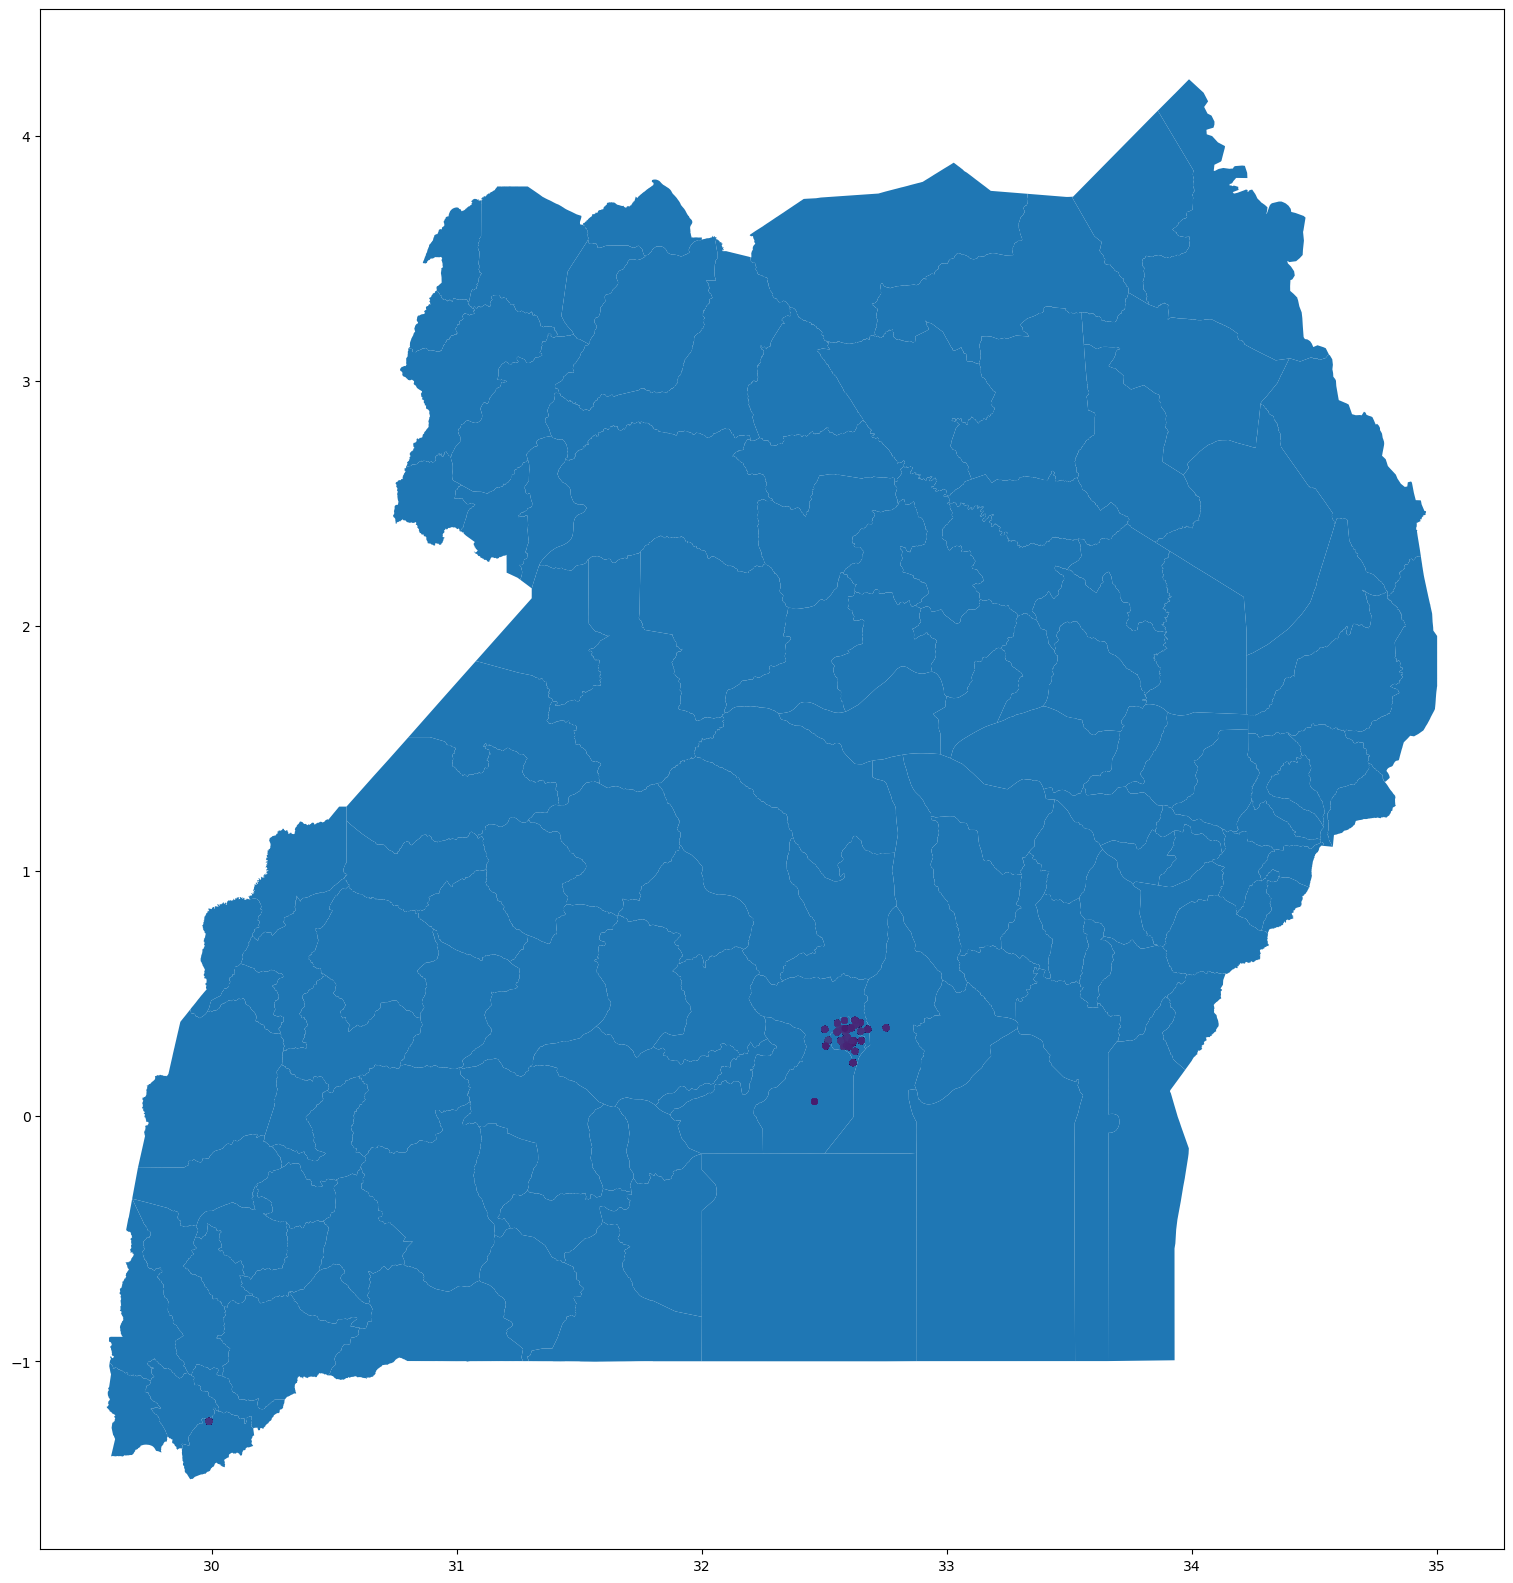

In [60]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
 
regions=gpd.read_file(r'C:\Users\hamdi\zindi\air quality\u\uga_admbnda_adm2_ubos_20200824.shp')


geometry = [Point(xy) for xy in zip(train['site_longitude'], train['site_latitude'])]
gdf = GeoDataFrame(train.copy(), geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=regions.plot(figsize=(50, 20)), marker='o', c=train.pm2_5, markersize=15)


# feature engineering

## Clustering by region


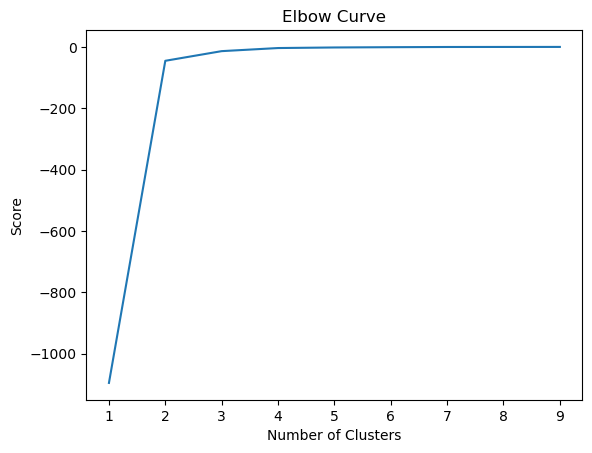

In [61]:
# firt of all we gonna cluster data by 3 regions
from sklearn.cluster import KMeans
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train[['site_latitude']]
X_axis = train[['site_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

from the elbow figure above the optimal k clusters is 2

In [62]:
kmeans = KMeans(n_clusters = 2, init ='k-means++')
kmeans.fit(train[train.columns[2:4]]) # Compute k-means clustering.
train['cluster_cor'] = kmeans.fit_predict(train[train.columns[2:4]])
test['cluster_cor'] = kmeans.fit_predict(test[test.columns[2:4]])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(train[train.columns[2:4]]) # Labels of each point
train["cluster_cor"].value_counts()

0    9470
1     453
Name: cluster_cor, dtype: int64

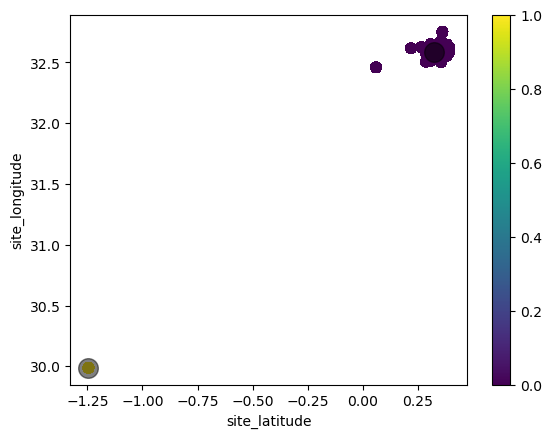

In [63]:
train.plot.scatter(x = 'site_latitude', y = 'site_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Filling or deleting missing values:
*columns with more than 50% of missing values are to be deleted* \
**my stategy for filling missing values is by already predicting them by previous values using ARIMA model**

In [64]:
#filling missing data

from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import statsmodels.api as sm

def fillna(df):
    df=df.copy()
    cols=df.columns
    for col in cols:
        if df[col].isna().any():
            serie=df[col]
            serie1=serie.asfreq('D').copy()
            #serie1=serie.copy()
            #model= sm.tsa.statespace.SARIMAX(serie1, trend='c', order=(2,1,1), seasonal_order=(4,1,2,3))
            model = sm.tsa.arima.ARIMA(serie1, order=(4,1,1))

            model.initialize_approximate_diffuse()
            #fit the model
            model_fit = model.fit()
            #get prediction start and end dates
            pred_start_date = serie.index[0]
            pred_end_date = serie.index[-1]
            #get the predictions and residuals
            predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
            serie=serie.fillna(predictions[serie.index])
            df.loc[:,col]=serie
    return df


In [65]:
## deleting columns

In [66]:
#train
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({
                                 'percent_missing': percent_missing})
cols=list(missing_value_df[missing_value_df["percent_missing"]>51].index)
train.drop(cols,axis=1,inplace=True)

In [67]:
#test
percent_missing = test.isnull().sum() * 100 / len(test)
missing_value_df = pd.DataFrame({
                                 'percent_missing': percent_missing})
cols=list(missing_value_df[missing_value_df["percent_missing"]>51].index)
test.drop(cols,axis=1,inplace=True)

In [68]:
cols=list(set(train.columns).intersection(test.columns))

In [69]:
train=train[cols+['pm2_5']]
test=test[cols]

In [70]:
test["pm2_5"]=np.nan
test["train"]=0
train["train"]=1

In [71]:
train_test=pd.concat([train,test])


In [72]:
for device in tqdm(train["device"].unique()):
    train_test.loc[train_test['device']==device]=fillna(train_test.loc[train_test['device']==device])
#train_test=train_test.interpolate()

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [11:09<00:00, 19.69s/it]


# Add new columns

![title](f.jpg)

In [73]:
def add_columns(df):
    df["date"]=df.index
    df["day"]=df["date"].dt.day
    df["month"]=df["date"].dt.month
    df['year'] = df['date'].dt.year

    df['dayofyear'] = df['date'].dt.dayofyear
    
    df['day_sin_y'] = np.sin(2 * np.pi * df['dayofyear']/365.0)
    df['day_cos_y'] = np.cos(2 * np.pi * df['dayofyear']/365.0)

    df['day_sin_m'] = np.sin(2 * np.pi * df['day']/31.0)
    df['day_cos_m'] = np.cos(2 * np.pi * df['day']/31.0)
    df['year'] = df['date'].dt.year
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['weekofyear'] = df['date'].dt.weekofyear

    df["day_count"]=(df["date"]-df["date"][0]).astype('timedelta64[D]')
    return df.drop("date",axis=1)

In [74]:
train_test=add_columns(train_test)

# one hot encoding for device

In [75]:
train_test=pd.get_dummies(train_test, columns = ["device"])

In [76]:
train_test.isna().sum().sum()

327

# model

## Xgboost

In [77]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [78]:
train=train_test[train_test["train"]==1].drop("train",axis=1)
test=train_test[train_test["train"]==0].drop("train",axis=1)
train=train.fillna(train.mean())
test["pm2_5"]=np.nan

In [79]:
X_train , y_train = train.drop(["pm2_5","ID"],axis=1).astype(float).iloc[:round(train.shape[0]*0.75)],train["pm2_5"].iloc[:round(train.shape[0]*0.75)]
X_val , y_val = train.drop(["pm2_5","ID"],axis=1).astype(float).iloc[round(train.shape[0]*0.75):],train["pm2_5"].iloc[round(train.shape[0]*0.75):]

X_test = test.drop(["pm2_5","ID"],axis=1).astype(float)


In [80]:
reg = xgb.XGBRegressor(n_estimators=10000,learning_rate=0.0025,tree_method='gpu_hist',eval_metric="mae",max_depth=10)
reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)],
            early_stopping_rounds=200,verbose=200)

[0]	validation_0-mae:52.77650	validation_1-mae:67.57739
[200]	validation_0-mae:32.37323	validation_1-mae:47.56761
[400]	validation_0-mae:20.10268	validation_1-mae:35.32124
[600]	validation_0-mae:12.90683	validation_1-mae:28.51281
[800]	validation_0-mae:8.80514	validation_1-mae:24.59690
[1000]	validation_0-mae:6.59071	validation_1-mae:22.55794
[1200]	validation_0-mae:5.41686	validation_1-mae:21.28574
[1400]	validation_0-mae:4.69423	validation_1-mae:20.49737
[1600]	validation_0-mae:4.29136	validation_1-mae:20.12497
[1800]	validation_0-mae:3.95423	validation_1-mae:19.80549
[2000]	validation_0-mae:3.71074	validation_1-mae:19.58310
[2200]	validation_0-mae:3.49070	validation_1-mae:19.46447
[2400]	validation_0-mae:3.27987	validation_1-mae:19.37072
[2600]	validation_0-mae:3.12383	validation_1-mae:19.31341
[2800]	validation_0-mae:2.94769	validation_1-mae:19.26447
[3000]	validation_0-mae:2.79812	validation_1-mae:19.22538
[3200]	validation_0-mae:2.67246	validation_1-mae:19.19871
[3400]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.0025, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

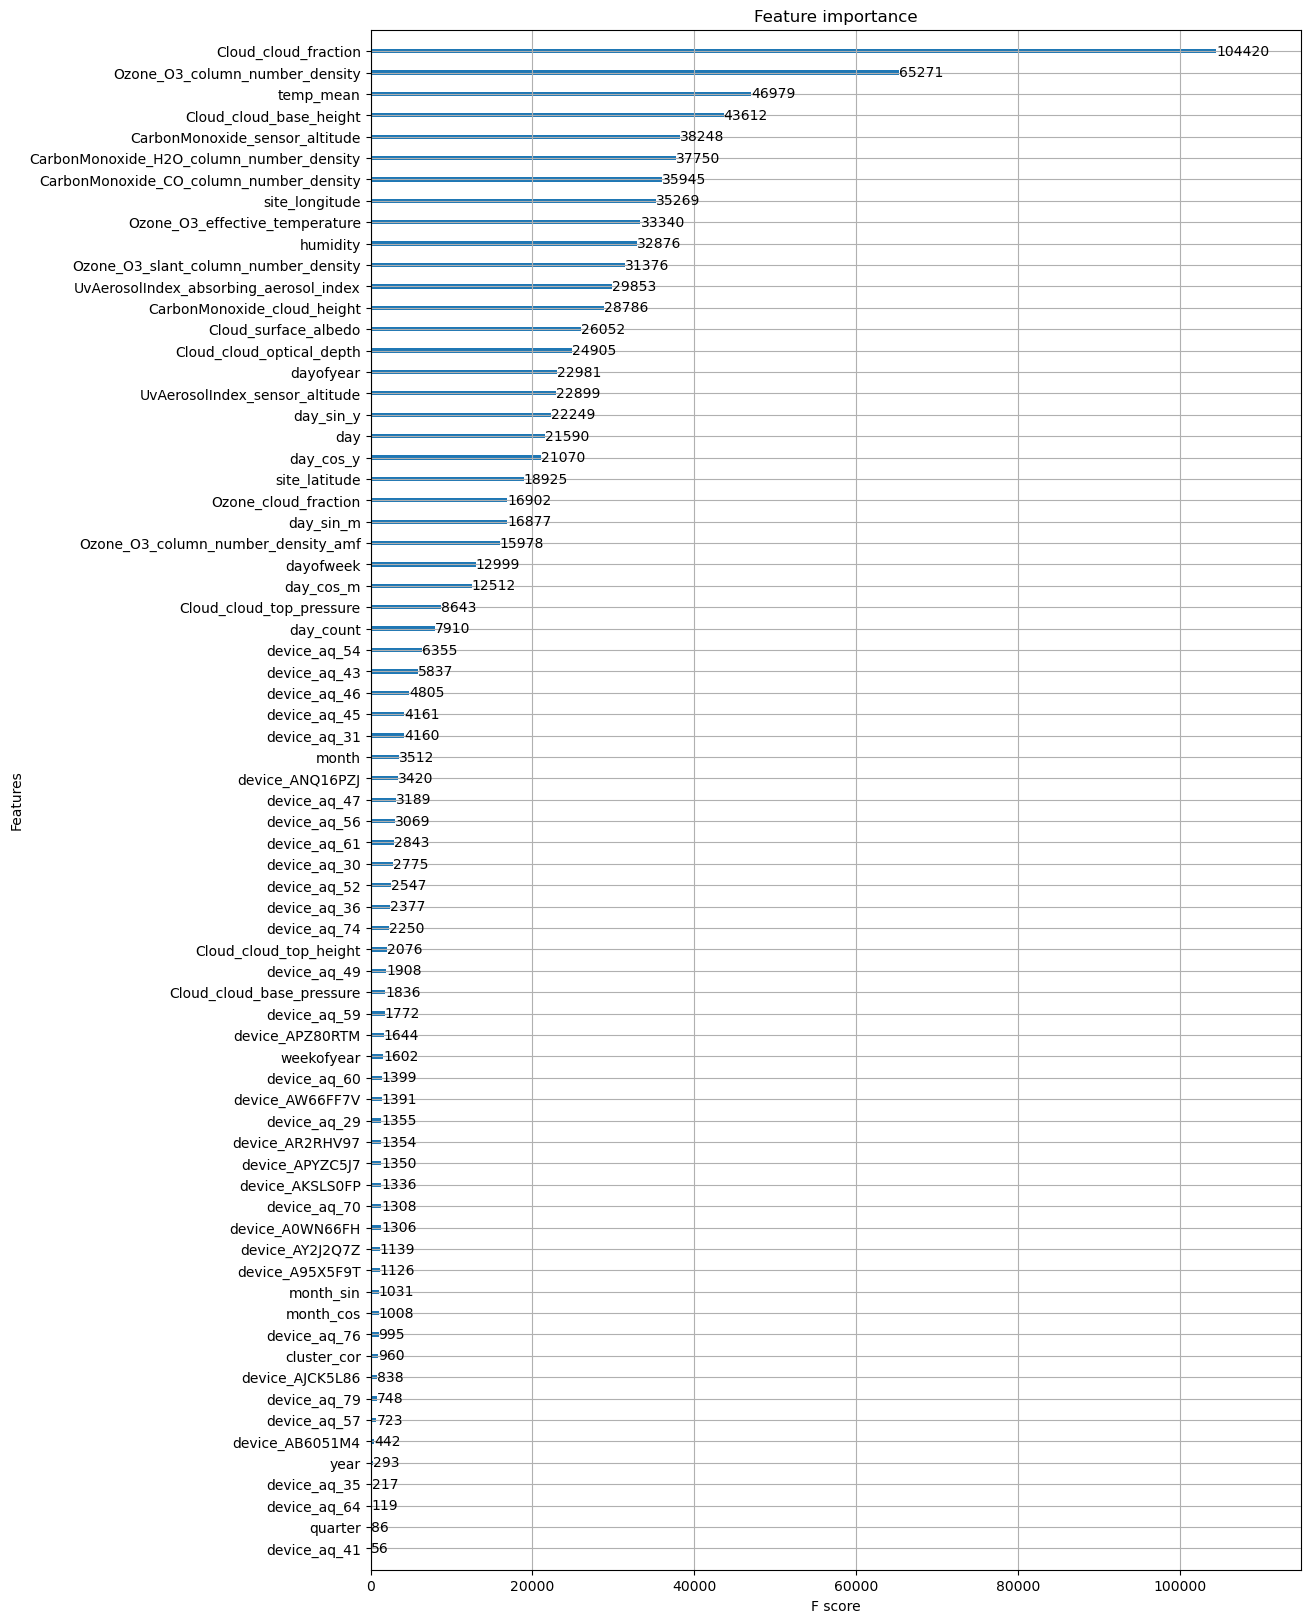

In [81]:
#plot_importance(reg, height=5,width=2)
ax =plot_importance(reg)
fig = ax.figure
fig.set_size_inches(12, 20)

## Random Forest Regressor

In [82]:
from sklearn.metrics import mean_absolute_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 20, oob_score = True,criterion='mae',random_state = 0,n_jobs=-1,verbose=10)

# Fitting the Random Forest Regression model to the data
model.fit(X_train, y_train)
# Predicting the target values of the test set
y_pred = model.predict(X_val)

# RMSE (Root Mean Square Error)
mae = mean_absolute_error(y_val, y_pred)
print("\nMAE: ", mae)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.0s


building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   15.7s remaining:   23.6s


building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   25.6s remaining:   20.9s


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   27.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   32.6s remaining:    5.7s



MAE:  18.757653571653293


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished
